# Machine Learning in Python - MNIST Fashion

## Data Prep

### Lots of Imports

In [1]:
#Install Dependencies
!pip install kaggle

    100% |████████████████████████████████| 61kB 840kB/s ta 0:00:01
    100% |████████████████████████████████| 245kB 1.7MB/s ta 0:00:01
  Stored in directory: /Users/bmacnamee/Library/Caches/pip/wheels/0d/58/eb/83d6a2e1935aff39d341ffa1e5faa3809e173cd0937e057d83
  Stored in directory: /Users/bmacnamee/Library/Caches/pip/wheels/2b/9e/c8/14a18ab55d8f144384de8186a3df8401dcc9264936f71d470f
Successfully built kaggle python-slugify
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


We need to Upload the our credentials of the Kaggle account in here befoew we could import any dataset. 


1.   Log into you Kaggle acount
2.   Click on the "your profile" icon on the top right of the page
3.   Click on My Account
4.   Below the page click on Create New API Token

The Kaggle.json file will be downloaded.

Now you can run the code block down below and upload the Kaggle.json file from your PC onto Google Colab. This way you can automatically loginto your Kaggle account with no problem and seamlessly.



In [0]:
# Upload the credentials of the Kaggle account
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehrandragon","key":"251e5b5a01ce62e6017d8d4d64e7786e"}'}

In [2]:
# Before importing the datasets we need to run the following code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In order to download a dataset from Kaggle, we need the API Command for that dataset. to get it, choose the dataset of your interest on Kaggle, then choose "**Copy API Command**" and paste it here RIGHT after the exclamation mark down below . For example, for the  Fashion MNIST dataset the API command is: 
***kaggle datasets download -d zalando-research/fashionmnist***

In [3]:
# Now we can import the dataset of interest
!kaggle datasets download -d zalando-research/fashionmnist

 16%|██████▏                                | 11.0M/68.8M [00:07<01:26, 698kB/s]/Users/bmacnamee/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|███████████████████████████████████████| 68.8M/68.8M [03:13<00:00, 348kB/s]



In [4]:
# We can see the imnported files from Kaggle
!ls

1_Machine_Learning_in_Python_MNIST_Fashion.ipynb
fashionmnist.zip
kaggle.json


In [5]:
# Now we will unzip the dataset
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: t10k-images-idx3-ubyte  
  inflating: fashion-mnist_test.csv  
  inflating: train-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-labels-idx1-ubyte  


In [6]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter

# from TAS_Python_Utilities import data_viz
# from TAS_Python_Utilities import data_viz_target
# from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network

%matplotlib inline
#%qtconsole

To build predictive models in Python we use a set of libraries that are imported here. In particular **pandas** and **sklearn** are particularly important.

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [7]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [8]:
cv_folds = 2

Set up a dictionary to store simple model perofrmance comparions

In [9]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### Load & Partition Data

Load the dataset and explore it.

In [10]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
58471,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11052,3,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
35739,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4374,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50677,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the distribution of the two classes

In [11]:
dataset["label"].value_counts()

8    646
9    617
0    612
1    608
5    602
3    597
6    594
4    594
7    572
2    558
Name: label, dtype: int64

In [12]:
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.531667,0.001000,0.004667,0.019167,0.051000,0.210167,0.357500,0.747000,2.105000,5.763167,...,34.515333,23.129500,16.904333,17.842833,21.945000,17.133833,8.332167,2.633333,0.845500,0.076500
std,2.895179,0.054768,0.190572,0.251946,0.980251,3.314236,4.967643,7.581242,13.801065,24.201791,...,57.362158,48.845642,42.437083,44.097826,50.863266,44.665644,29.833893,16.919789,9.666896,2.463262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,4.000000,14.000000,14.000000,68.000000,110.000000,156.000000,185.000000,215.000000,237.000000,...,255.000000,255.000000,246.000000,255.000000,255.000000,255.000000,252.000000,238.000000,255.000000,155.000000


In [13]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum())

Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [0]:
# Visualise fields
#data_viz(dataset)

In [0]:
# Visualise fields in relation to target
#data_viz_target(dataset, "label")

Isolate the descriptive features we are interested in

In [14]:
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

Display some of the images

[ 5232 ]  Pullover


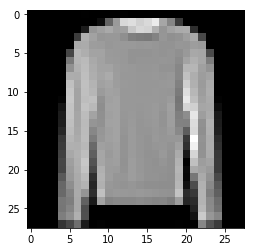

[ 3030 ]  Sandal


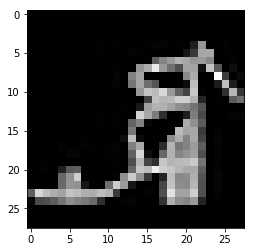

[ 4600 ]  Pullover


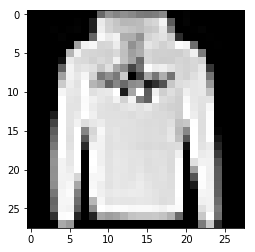

[ 5490 ]  Sneaker


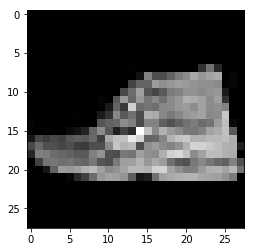

[ 2507 ]  Sandal


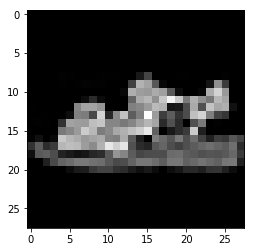

[ 4537 ]  Sandal


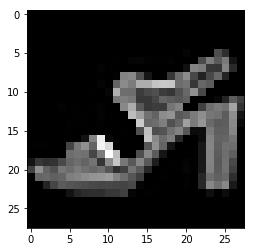

[ 3377 ]  Trouser


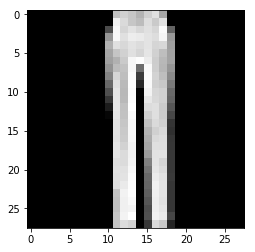

[ 2263 ]  Ankle boot


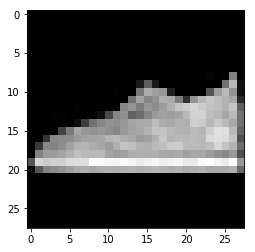

[ 1964 ]  Pullover


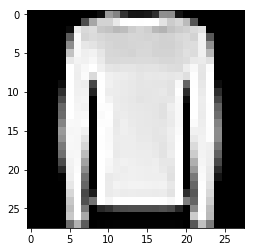

In [15]:
# create a sample of images from the dataset
for i in range(0, 9):
    i_rand = randint(0, X.shape[0])

    print("[", i_rand, "] ", classes[Y[i_rand]])
    two_d = (X.iloc[i_rand].values.reshape(28, 28))
    pyplot.imshow(two_d, cmap='gray')
    pyplot.show()


Normalise the data (important for some models)

In [16]:
X = X/255

Split the data into a **training set**, a **vaidation set**, and a **test set**

In [17]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

/Users/bmacnamee/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Building Simple Models

### A Very Simple Decision Tree

Train a decision tree

In [18]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Visualise the decision tree so we can see what it is doing!

In [19]:
#feature_names = list(X_train.columns)
#visualize_tree(my_tree, feature_names, fileName='dt_over.png')
#Image(filename='dt_over.png') 

### Evaluating Model Performance

Assess the performance of the decision tree on the training set

In [20]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       292
          1       1.00      1.00      1.00       303
          2       1.00      1.00      1.00       301
          3       1.00      1.00      1.00       292
          4       1.00      1.00      1.00       298
          5       1.00      1.00      1.00       321
          6       1.00      1.00      1.00       297
          7       1.00      1.00      1.00       272
          8       1.00      1.00      1.00       323
          9       1.00      1.00      1.00       301

avg / total       1.00      1.00      1.00      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,292,0,0,0,0,0,0,0,0,0,292
1,0,303,0,0,0,0,0,0,0,0,303
2,0,0,301,0,0,0,0,0,0,0,301
3,0,0,0,292,0,0,0,0,0,0,292
4,0,0,0,0,298,0,0,0,0,0,298
5,0,0,0,0,0,321,0,0,0,0,321
6,0,0,0,0,0,0,297,0,0,0,297
7,0,0,0,0,0,0,0,272,0,0,272
8,0,0,0,0,0,0,0,0,323,0,323


Assess the performance of the tree on the validation dataset

In [21]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7116666666666667
             precision    recall  f1-score   support

          0       0.70      0.63      0.66       128
          1       0.92      0.92      0.92       120
          2       0.52      0.60      0.56       100
          3       0.74      0.77      0.75       117
          4       0.61      0.54      0.57       139
          5       0.85      0.81      0.83       111
          6       0.45      0.52      0.49       124
          7       0.72      0.80      0.76       119
          8       0.84      0.76      0.80       124
          9       0.83      0.80      0.81       118

avg / total       0.72      0.71      0.71      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,81,0,5,6,4,0,29,0,3,0,128
1,2,110,5,2,0,0,1,0,0,0,120
2,3,0,60,1,20,0,12,0,4,0,100
3,7,8,1,90,3,1,6,0,0,1,117
4,1,1,25,11,75,0,22,0,4,0,139
5,0,0,0,0,0,90,1,13,3,4,111
6,19,0,14,5,16,1,65,0,4,0,124
7,0,0,0,0,0,11,0,95,0,13,119
8,3,0,5,6,4,1,7,3,94,1,124


Assess the performance of the tree on the validation dataset

In [22]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7377777777777778
             precision    recall  f1-score   support

          0       0.70      0.66      0.68       192
          1       0.91      0.89      0.90       185
          2       0.60      0.61      0.60       157
          3       0.68      0.73      0.70       188
          4       0.54      0.52      0.53       157
          5       0.85      0.78      0.81       170
          6       0.50      0.55      0.52       173
          7       0.85      0.85      0.85       181
          8       0.88      0.84      0.86       199
          9       0.85      0.89      0.87       198

avg / total       0.74      0.74      0.74      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,126,0,9,17,0,1,36,0,3,0,192
1,3,164,4,8,1,0,2,1,2,0,185
2,4,0,95,2,31,0,22,0,3,0,157
3,15,13,2,138,8,2,7,1,1,1,188
4,3,2,26,19,81,0,22,0,4,0,157
5,2,0,0,2,0,132,1,11,6,16,170
6,21,1,18,10,24,0,95,0,4,0,173
7,0,0,0,0,0,13,0,153,0,15,181
8,3,0,3,6,6,4,6,3,168,0,199


### Less Overiftted Decision Tree

Train a decision tree, setting min samples per leaf to a sensible value

In [23]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
my_tree = my_tree.fit(X_train,y_train)

Visualise the decision tree so we can see what it is doing!

In [24]:
# visualise the decision tree
#feature_names = list(X_train.columns)
#visualize_tree(my_tree, feature_names, fileName="dt_under.png")
#Image(filename='dt_under.png') 

Assess the performance of the decision tree on the **training set**

In [25]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7436666666666667
             precision    recall  f1-score   support

          0       0.73      0.77      0.75       292
          1       1.00      0.84      0.91       303
          2       0.57      0.81      0.67       301
          3       0.60      0.80      0.69       292
          4       0.68      0.50      0.58       298
          5       0.77      0.86      0.81       321
          6       0.58      0.24      0.34       297
          7       0.80      0.86      0.83       272
          8       0.83      0.87      0.85       323
          9       0.92      0.87      0.90       301

avg / total       0.75      0.74      0.73      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,226,0,16,34,1,2,0,0,13,0,292
1,1,255,0,42,0,5,0,0,0,0,303
2,4,0,243,5,18,0,26,0,5,0,301
3,8,0,19,235,2,26,1,0,1,0,292
4,3,0,71,44,149,0,24,0,7,0,298
5,3,0,0,0,0,275,0,29,9,5,321
6,65,0,70,25,46,1,71,0,19,0,297
7,0,0,0,0,0,17,0,234,3,18,272
8,1,0,10,4,2,26,0,0,280,0,323


Assess the performance of the decision tree on the **validation set**

In [26]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.6958333333333333
             precision    recall  f1-score   support

          0       0.69      0.82      0.75       128
          1       0.95      0.86      0.90       120
          2       0.49      0.85      0.62       100
          3       0.59      0.74      0.66       117
          4       0.62      0.35      0.44       139
          5       0.65      0.86      0.74       111
          6       0.61      0.22      0.32       124
          7       0.78      0.79      0.78       119
          8       0.80      0.77      0.78       124
          9       0.86      0.81      0.83       118

avg / total       0.71      0.70      0.68      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,105,0,8,10,1,1,0,0,3,0,128
1,2,103,5,7,0,3,0,0,0,0,120
2,2,0,85,0,5,0,4,0,4,0,100
3,7,3,4,86,0,17,0,0,0,0,117
4,0,1,44,27,48,0,13,0,6,0,139
5,1,0,0,0,0,96,0,7,3,4,111
6,33,1,20,13,21,2,27,0,7,0,124
7,0,0,0,0,0,13,0,94,0,12,119
8,2,0,8,2,2,14,0,1,95,0,124


In [27]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.7088888888888889
             precision    recall  f1-score   support

          0       0.71      0.73      0.72       192
          1       0.96      0.84      0.90       185
          2       0.55      0.81      0.65       157
          3       0.60      0.78      0.68       188
          4       0.51      0.38      0.44       157
          5       0.64      0.75      0.69       170
          6       0.66      0.26      0.37       173
          7       0.76      0.86      0.81       181
          8       0.80      0.76      0.78       199
          9       0.90      0.84      0.87       198

avg / total       0.72      0.71      0.70      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,141,1,7,26,1,1,0,0,15,0,192
1,2,155,7,19,0,2,0,0,0,0,185
2,5,0,127,2,15,0,4,0,4,0,157
3,10,4,10,147,1,16,0,0,0,0,188
4,3,1,45,28,60,0,19,0,1,0,157
5,1,0,0,0,0,127,0,28,4,10,170
6,33,0,27,20,37,0,45,0,11,0,173
7,0,0,0,0,0,17,0,155,0,9,181
8,3,0,8,4,3,26,0,3,152,0,199


## Choosing Parameters Using a Grid Search

Use a cross validation to perfrom an evaluation

In [28]:
my_tree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(my_tree, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)

[0.74823529 0.7464455  0.72921615 0.75       0.73095238 0.72619048
 0.74761905 0.73205742 0.73444976 0.76442308]


An alternative to using post pruning explicitly is to use a grid search through a large set of possible parameters. Here we try depths between 3 and 20 and different limits on the minimum number of samples per split.

In [29]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=15, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=15, min_samples_split=200 ..........

[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.5s
[CV] criterion=entropy, max_depth=45, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=45, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=45, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=45, min_samples_split=200, total=   0.5s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.5s


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   23.9s finished


Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 200}

0.6902380952380952

{'mean_fit_time': array([0.17427051, 0.29040933, 0.29170454, 0.3037529 , 0.27801788,
        0.27113903, 0.27169704, 0.26272297, 0.26308298, 0.26486301,
        0.2801199 , 0.28788519, 0.29952598, 0.28118944, 0.2838695 ,
        0.30352557, 0.2568351 , 0.46159637, 0.44768941, 0.45452452,
        0.45159161, 0.44803488, 0.44784856, 0.48169899, 0.48510253,
        0.48310244, 0.469733  , 0.46219254, 0.46866906, 0.46726251,
        0.46606326, 0.46651292]),
 'mean_score_time': array([0.00439465, 0.00368178, 0.00360608, 0.00450003, 0.00284398,
        0.00324094, 0.00424194, 0.00274861, 0.00283086, 0.00318491,
        0.00329006, 0.00430489, 0.00393355, 0.00527203, 0.00305355,
        0.0041759 , 0.00308335, 0.00309956, 0.00376606, 0.00308645,
        0.00292432, 0.00291407, 0.00436711, 0.00493491, 0.00388932,
        0.00421607, 0.00328803, 0.00309992, 0.004439  , 0.00462842,
        0.00329006, 0.00369823]),
 'mean_test_score': array([0.45380952, 0.68214286, 0.6802381 , 0.6802381 , 0.680

Evaluate the performance of the tuned tree

In [30]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7455555555555555
             precision    recall  f1-score   support

          0       0.77      0.71      0.74       192
          1       0.98      0.83      0.90       185
          2       0.69      0.61      0.65       157
          3       0.54      0.89      0.67       188
          4       0.57      0.51      0.54       157
          5       0.79      0.74      0.76       170
          6       0.58      0.45      0.51       173
          7       0.81      0.86      0.84       181
          8       0.85      0.90      0.88       199
          9       0.93      0.86      0.89       198

avg / total       0.76      0.75      0.75      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,137,0,4,33,2,1,2,0,13,0,192
1,1,153,6,23,1,1,0,0,0,0,185
2,0,0,96,5,39,0,14,0,3,0,157
3,8,2,5,167,1,1,1,0,3,0,188
4,1,1,11,33,80,0,31,0,0,0,157
5,0,0,2,11,0,125,0,25,3,4,170
6,32,0,15,26,14,0,78,0,8,0,173
7,0,0,0,1,0,16,0,156,0,8,181
8,0,0,1,4,3,3,7,1,180,0,199


Visualise the tree

In [31]:
best_tree = tree.DecisionTreeClassifier(min_samples_split=200, criterion='gini', max_depth=8)
best_tree = best_tree.fit(X_train, y_train)

# visualise the decision tree
#feature_names = list(X_train.columns)
#visualize_tree(best_tree, feature_names, 'dt_tuned.png')
#Image(filename='dt_tuned.png') 

## Comparing Models

We can easily use the same patterns to train other types of models.

#### Random Forests

Train and evaluate a simple model 

In [32]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300, \
                                           max_features = 3,\
                                           min_samples_split=200)
my_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7608333333333334
             precision    recall  f1-score   support

          0       0.72      0.84      0.78       128
          1       0.87      0.92      0.89       120
          2       0.56      0.75      0.64       100
          3       0.69      0.82      0.75       117
          4       0.64      0.60      0.62       139
          5       0.92      0.79      0.85       111
          6       0.64      0.23      0.33       124
          7       0.82      0.83      0.82       119
          8       0.91      0.93      0.92       124
          9       0.82      0.94      0.88       118

avg / total       0.76      0.76      0.75      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,108,0,2,8,2,0,5,0,3,0,128
1,2,110,5,3,0,0,0,0,0,0,120
2,3,0,75,0,18,0,3,0,1,0,100
3,2,12,3,96,1,0,3,0,0,0,117
4,1,3,24,21,83,0,5,0,2,0,139
5,0,0,0,0,0,88,0,14,0,9,111
6,33,1,23,9,25,0,28,0,5,0,124
7,0,0,0,0,0,5,0,99,0,15,119
8,0,0,1,2,1,3,0,2,115,0,124


Choose parameters using a grid search

In [34]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [200] }
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Random Forest"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.5s
[CV] max_features=2, min_samples_sp

[CV]  max_features=8, min_samples_split=200, n_estimators=150, total=   0.4s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   0.7s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   0.7s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   0.9s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.0s
[CV] max_features=8, min_samples_sp

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.8s finished


Best parameters set found on development set:
{'max_features': 8, 'min_samples_split': 200, 'n_estimators': 350}
0.7714285714285715


In [35]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7911111111111111
             precision    recall  f1-score   support

          0       0.75      0.81      0.78       192
          1       0.99      0.87      0.93       185
          2       0.69      0.73      0.71       157
          3       0.66      0.86      0.74       188
          4       0.56      0.63      0.59       157
          5       0.90      0.86      0.88       170
          6       0.70      0.33      0.45       173
          7       0.88      0.83      0.86       181
          8       0.90      0.94      0.92       199
          9       0.89      0.95      0.92       198

avg / total       0.80      0.79      0.78      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,155,0,5,21,1,0,0,0,10,0,192
1,1,161,4,15,4,0,0,0,0,0,185
2,2,0,115,1,29,0,7,0,3,0,157
3,8,2,3,162,9,0,4,0,0,0,188
4,0,0,20,27,99,0,10,0,1,0,157
5,0,0,0,0,0,147,0,16,2,5,170
6,41,0,18,18,36,0,57,0,3,0,173
7,0,0,0,0,0,12,0,151,0,18,181
8,0,0,2,3,0,2,3,0,188,1,199


#### Bagging

Train and evaluate a simple model 

In [36]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [ ]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7533333333333333
             precision    recall  f1-score   support

          0       0.72      0.84      0.78       128
          1       0.92      0.88      0.90       120
          2       0.56      0.64      0.60       100
          3       0.69      0.74      0.71       117
          4       0.68      0.70      0.69       139
          5       0.71      0.86      0.78       111
          6       0.65      0.33      0.44       124
          7       0.86      0.80      0.83       119
          8       0.85      0.81      0.83       124
          9       0.86      0.93      0.89       118

avg / total       0.75      0.75      0.75      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,108,0,3,8,3,0,2,0,4,0,128
1,1,106,5,5,0,3,0,0,0,0,120
2,2,0,64,0,25,0,7,0,2,0,100
3,4,6,3,86,1,15,2,0,0,0,117
4,1,1,12,14,97,1,9,0,4,0,139
5,1,0,0,0,0,96,0,9,2,3,111
6,30,2,19,11,14,1,41,0,6,0,124
7,0,0,0,0,0,9,0,95,0,15,119
8,2,0,8,1,2,8,2,0,101,0,124


Choose parameters using a grid search

In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   5.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=No

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   5.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_spl

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350, total=  39.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350 


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

#### AdaBoost

Train and evaluate a simple model 

In [ ]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 200), \
                                       n_estimators=10)
my_model.fit(X_train,y_train)

In [ ]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Choose parameters using a grid search

In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.AdaBoostClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned AdaBoost"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

#### Logistic Regression

Train and evaluate a simple model 

In [ ]:
# Do the same job with logistic regression
my_model = linear_model.LogisticRegression()
my_model.fit(X_train,y_train)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Choose parameters using a grid search

In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Logistic Regression"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

#### Nearest Neighbour

Train and evaluate a simple model 

In [ ]:
# Do the same job with random forests
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X_train,y_train)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Choose parameters using a grid search

In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

### Multi Layer Perceptron

Train and evaluate a simple model 

In [ ]:
# Do the same job with random forests
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100))
my_model = my_model.fit(X_train,y_train)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Choose parameters using a grid search

In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(neural_network.MLPClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned MLP"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

### Compare Results

In [ ]:
display(model_test_accuracy_comparisons)

In [ ]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [ ]:
display(model_valid_accuracy_comparisons)

In [ ]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

In [ ]:
display(model_tuned_params_list)

### Test Best Model On Test Dataset

In [ ]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

In [ ]:
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])

In [ ]:
test_X = test_X/255

In [ ]:
my_model = linear_model.LogisticRegression(C=0.4,max_iter = 1000,multi_class='ovr',solver='liblinear')
my_model = my_model.fit(X,Y)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)